In [1]:
from datetime import datetime
import os
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv

In [2]:
# The variables we expect to be loaded in .env (or Jupyter runtime environment)
# PATH_TO_INPUT_CSV=str representing filepath of input PG&E Green Button Hourly CSV
# PATH_TO_NEST_THERMOSTAT_CSV_ROOT_FOLDER=str Path representing root folder path to YYYY/MM/*.csv files from Nest (Google Takeout download)
load_dotenv()

True

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = [16.0, 6.0]

In [4]:
# Adjust this to the bounds of your data set.
# This should ideally start and end at a boundary point that would contain full months of data
query_start = datetime(2018, 8, 1)
query_end =  datetime(2021, 1, 31)

## Load PG&E data from disk

In [5]:
df_csv = pd.read_csv(os.getenv('PATH_TO_INPUT_CSV'))

In [6]:
features_to_copy = {
    'date': 'DATE',
    'start_time': 'START TIME',
    'usage_kwh': 'USAGE',
    'cost_display': 'COST',
}

features = {
    'dt': lambda df: df.apply(lambda row: datetime.strptime(f'{row.date}T{row.start_time}', '%Y-%m-%dT%H:%M'), axis=1),
    'day_of_year': lambda df: df.dt.apply(lambda d: d.dayofyear),
    'day_of_week': lambda df: df.dt.apply(lambda d: d.dayofweek),
    'week_of_year': lambda df: df.dt.apply(lambda d: d.weekofyear),
    'year': lambda df: df.dt.apply(lambda d: d.year),
    'month': lambda df: df.dt.apply(lambda d: d.month),
    'hour': lambda df: df.dt.apply(lambda d: d.hour),
    'cost_cents': lambda df: df.cost_display.apply(lambda c: int(float(c[1:]) * 100))
}

In [7]:
df_energy = pd.DataFrame()

In [8]:
for newattr, oldattr in features_to_copy.items():
    df_energy[newattr] = df_csv[oldattr]

for attr, transform in features.items():
    df_energy[attr] = transform(df_energy)

In [9]:
# Truncate to dataset bounds
df_energy = df_energy[(df_energy.date >= query_start.strftime('%Y-%m-%d')) & (df_energy.date <= query_end.strftime('%Y-%m-%d'))]

### Quick sanity check of data

<AxesSubplot:xlabel='month', ylabel='usage_kwh'>

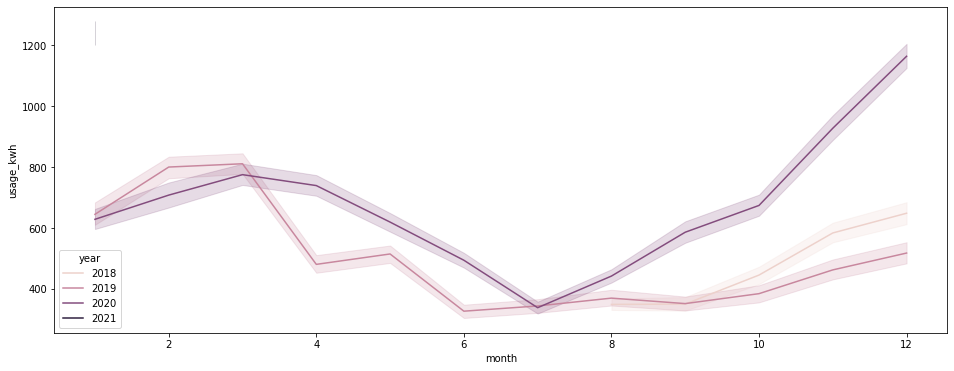

In [10]:
sns.lineplot(data=df_energy, x='month', y='usage_kwh', hue="year", estimator=np.sum)

<AxesSubplot:xlabel='month', ylabel='cost_cents'>

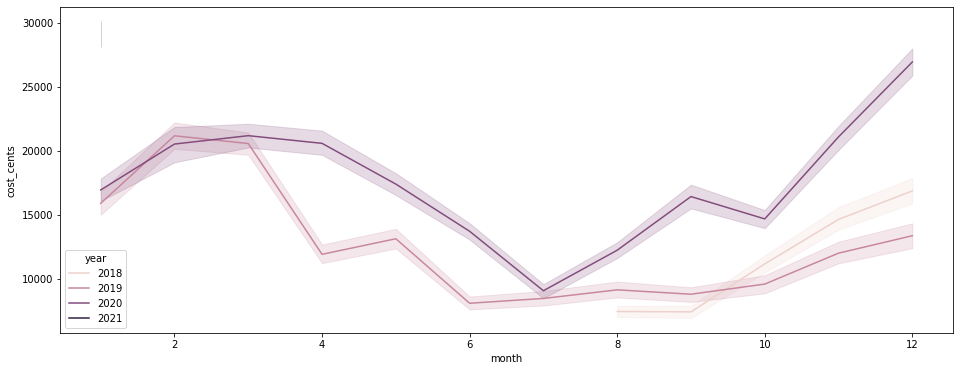

In [11]:
sns.lineplot(data=df_energy, x='month', y='cost_cents', hue="year", estimator=np.sum)

## Get the weather

We'll fetch the weather from the [Meteostat service](https://dev.meteostat.net/python/hourly.html#example).

You'll want to adjust the city/location in the `Point` constructor below, and add your custom query bounds.

In [12]:
import sys
!{sys.executable} -m pip install meteostat > /dev/null

In [13]:
from meteostat import Point, Hourly

In [14]:
# Adjust this for your desired location
oakland = Point(lat=37.8060361, lon=-122.2135176, alt=10)

In [15]:
data = Hourly(oakland, query_start, query_end)
df_weather = data.fetch()

### Quick sanity check

In [16]:
df_weather['rolling_3hr_temp'] = df_weather.temp.rolling(3, min_periods=1).mean()

<AxesSubplot:xlabel='time', ylabel='rolling_3hr_temp'>

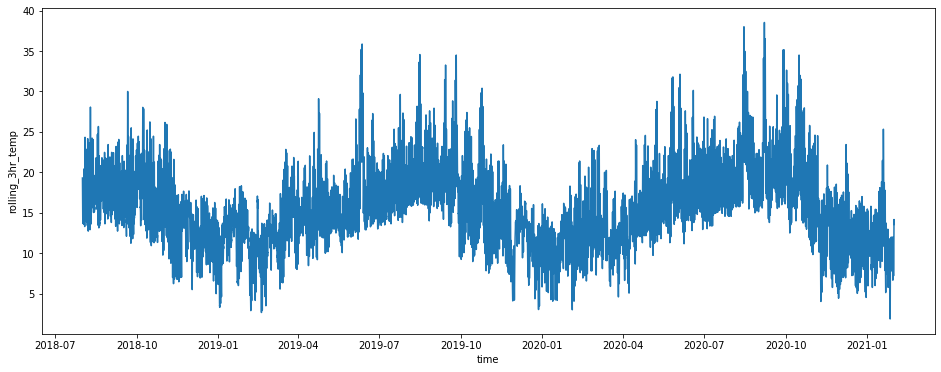

In [17]:
sns.lineplot(data=df_weather, x='time', y='rolling_3hr_temp')

## Merge data sets

In [18]:
df = df_weather.join(df_energy.set_index('dt'))

In [19]:
# Filter out na values
df = df[df.usage_kwh.notna()]

## Initial investigations

Let's just do a sanity check of our data.

In [20]:
corr = df.corr()

<AxesSubplot:>

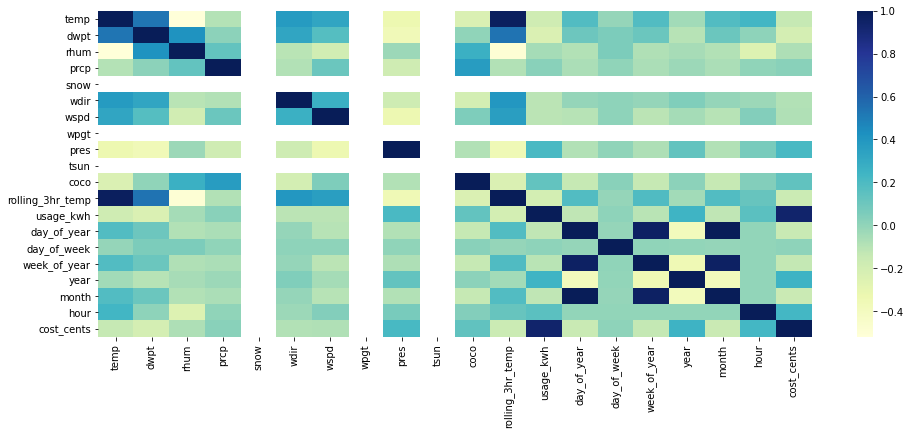

In [21]:
sns.heatmap(corr, cmap="YlGnBu")

I'm not seeing much correlation here, with the exception perhaps of pressure and usage

## Overall Energy Usage Analysis

First we plot the general shape of our energy usage over time

Text(0.5, 1.0, 'Weekly Energy Use')

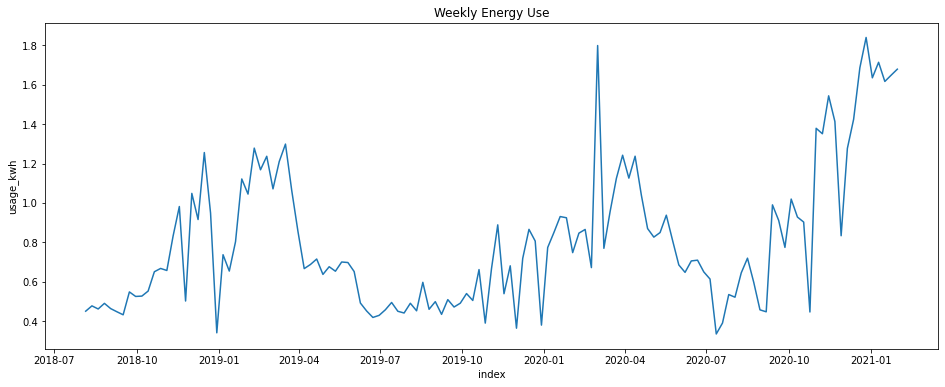

In [141]:
sns.lineplot(data=df.resample('W').mean().reset_index(), x='index', y='usage_kwh').set_title('Weekly Energy Use')

Let's plot each year on top of each other:

Text(0.5, 1.0, 'Weekly Energy Use')

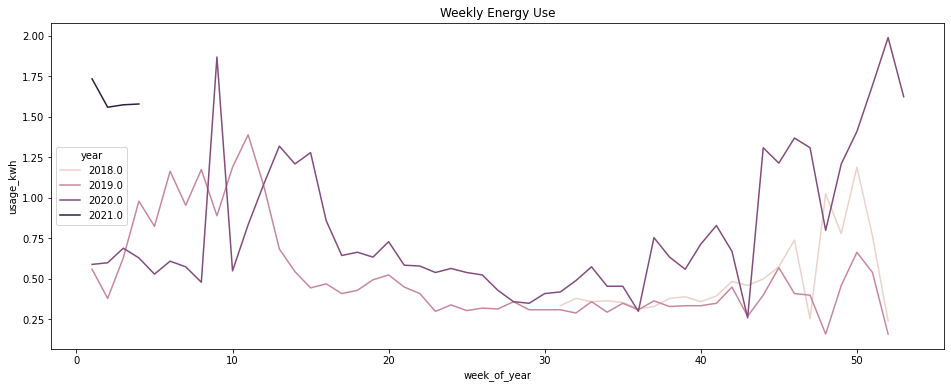

In [144]:
sns.lineplot(data=df.resample('W').median().reset_index(), x='week_of_year', y='usage_kwh', hue="year").set_title('Weekly Energy Use')

We note that:
- There are spikes as expected in the winter, as energy usage goes up with more dark hours and more usage of electric space heaters.
- 2020 was a banner year for energy usage in general due to COVID
- A PHEV car purchase in September 2020 meant extra electricity consumption in those months.

Questions we want answered:
- How much extra energy consumption can be attributed to COVID and stay at home?
- How much extra energy consumption can be attributed to the car?

## Hourly Analysis

We begin by plotting 

In [66]:
def plot_hour(hour):
    """
    Plot an hourly graph of usage
    """
    df_hourly = df[df.hour == hour].reset_index().copy()
    df_hourly['usage_kwh_rolling'] = df_hourly.usage_kwh.rolling(7).mean()
    df_hourly['usage_kwh_previous_year'] = df_hourly.usage_kwh_rolling.shift(365)
    df_hourly['usage_kwh_yoy'] = df_hourly.usage_kwh_rolling - df_hourly.usage_kwh_previous_year
    sns.lineplot(data=df_hourly[df_hourly.hour == hour], x='index', y='usage_kwh_rolling', hue='year', estimator=np.sum).set_title(f'Usage at {hour}:00')

In [117]:
def hourly_yoy_computation(df_hour):
    """
    Assemble a dataframe that contains YoY data for a single hour slice.
    Remember that the interval of this df is weekly
    """
    df_temp = pd.DataFrame()
    df_resampled = df_hour.resample('W')
    df_temp['month'] = df_resampled.month.min()
    df_temp['week_of_year'] = df_resampled.week_of_year.min()
    df_temp['year'] = df_resampled.year.min()
    # 3-week rolling average of this hour slice for smoothing
    df_temp['usage_kwh_rolling'] = df_resampled.usage_kwh.median().rolling(3).mean()
    df_temp['last_year'] = df_temp.usage_kwh_rolling.shift(52)
    df_temp['yoy_delta'] = df_temp.usage_kwh_rolling - df_temp.last_year
    df_temp['delta_yoy_cumulative'] = df_temp['yoy_delta'].cumsum()
    df_temp['usage_cumulative'] = df_temp.usage_kwh_rolling.cumsum()
    df_temp['usage_weekly_pct_change'] = df_temp.usage_kwh_rolling.pct_change(periods=1)
    df_temp['usage_monthly_pct_change'] = df_temp.usage_kwh_rolling.pct_change(periods=4)
    df_temp['usage_yearly_pct_change'] = df_temp.usage_kwh_rolling.pct_change(periods=52)
    return df_temp
df_hourly_yoy = df.groupby(by='hour').apply(hourly_yoy_computation)

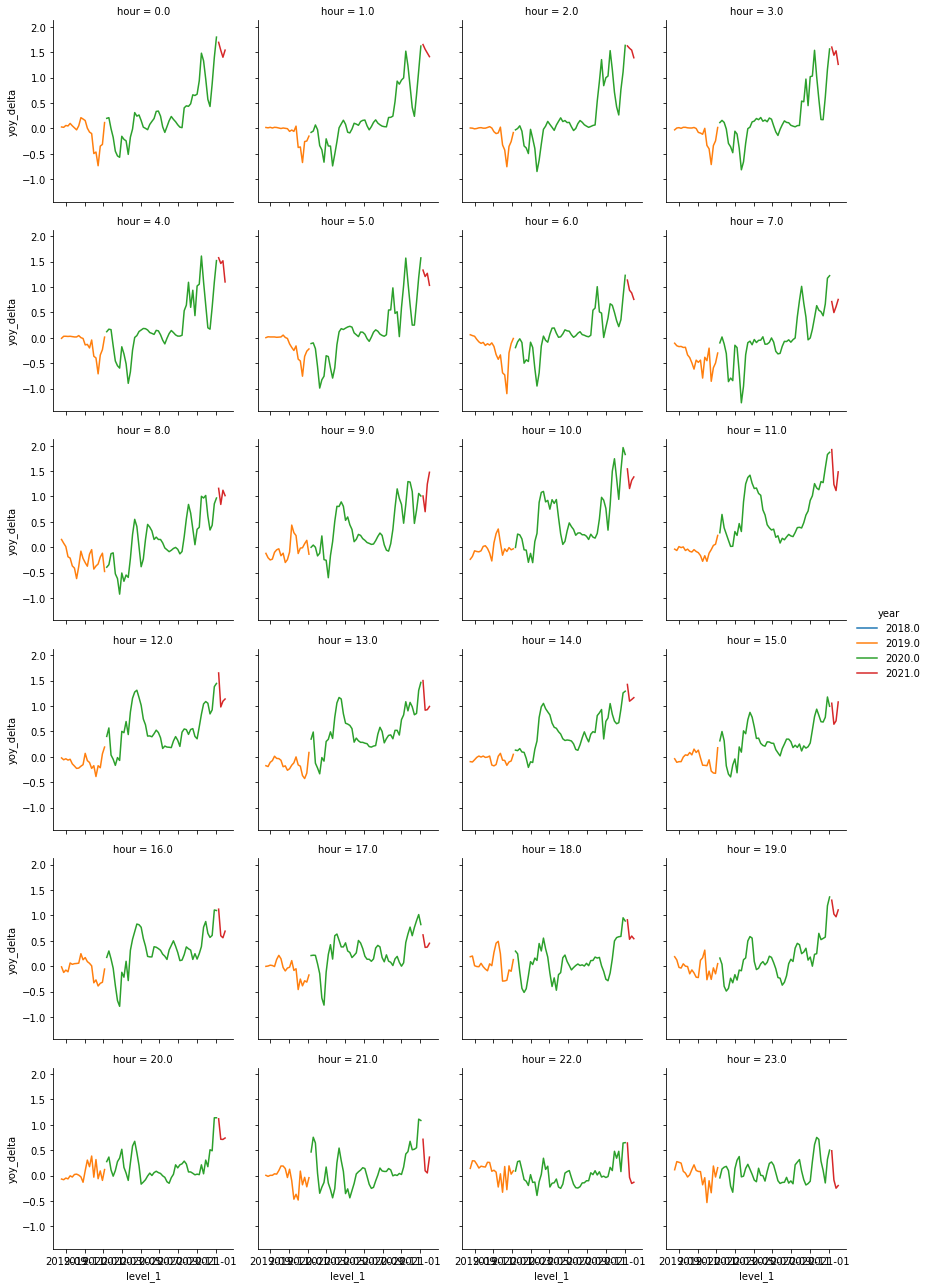

In [118]:
g = sns.FacetGrid(df_hourly_yoy.reset_index(), hue='year', col="hour", col_wrap=4)
g.map(sns.lineplot, "level_1", "yoy_delta")
g.add_legend()

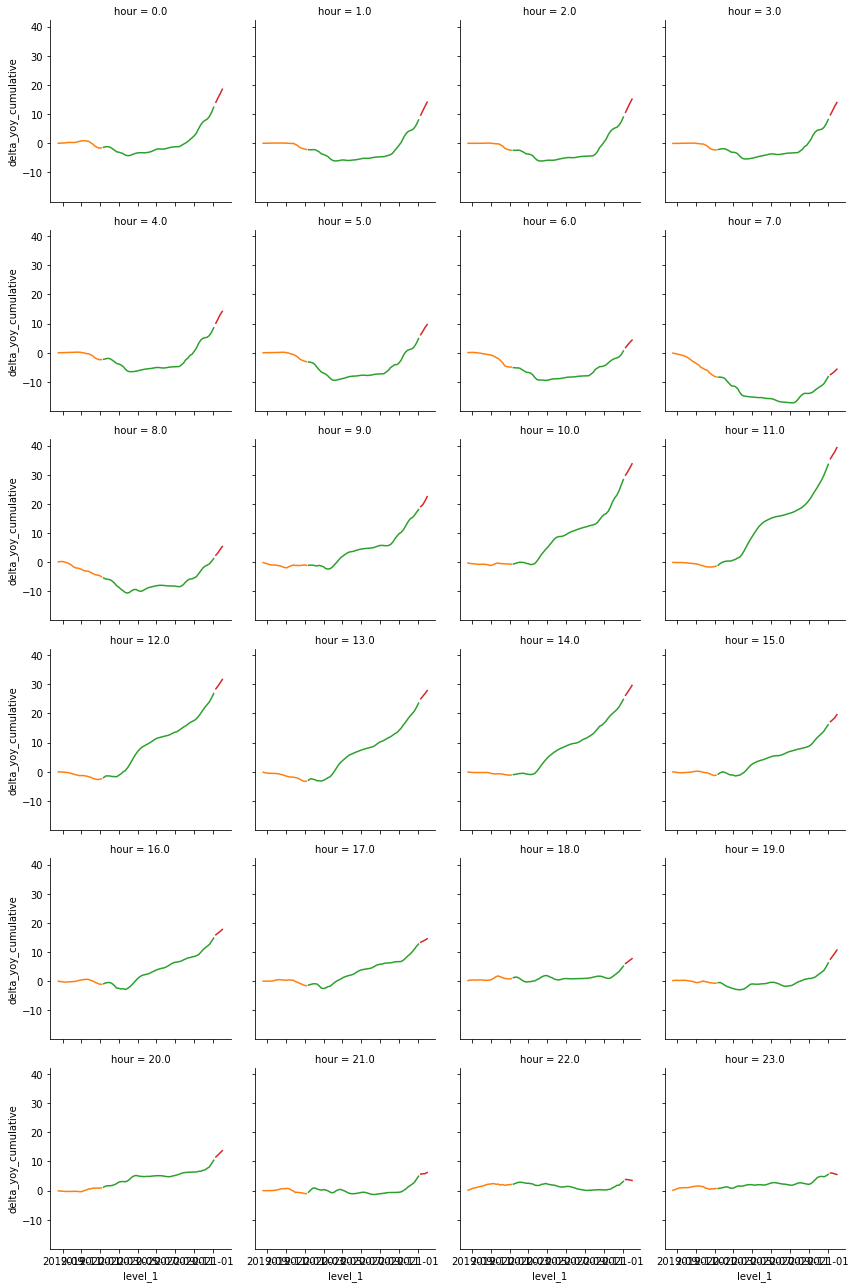

In [119]:
g = sns.FacetGrid(df_hourly_yoy.reset_index(), hue='year', col="hour", col_wrap=4)
g.map(sns.lineplot, "level_1", "delta_yoy_cumulative")

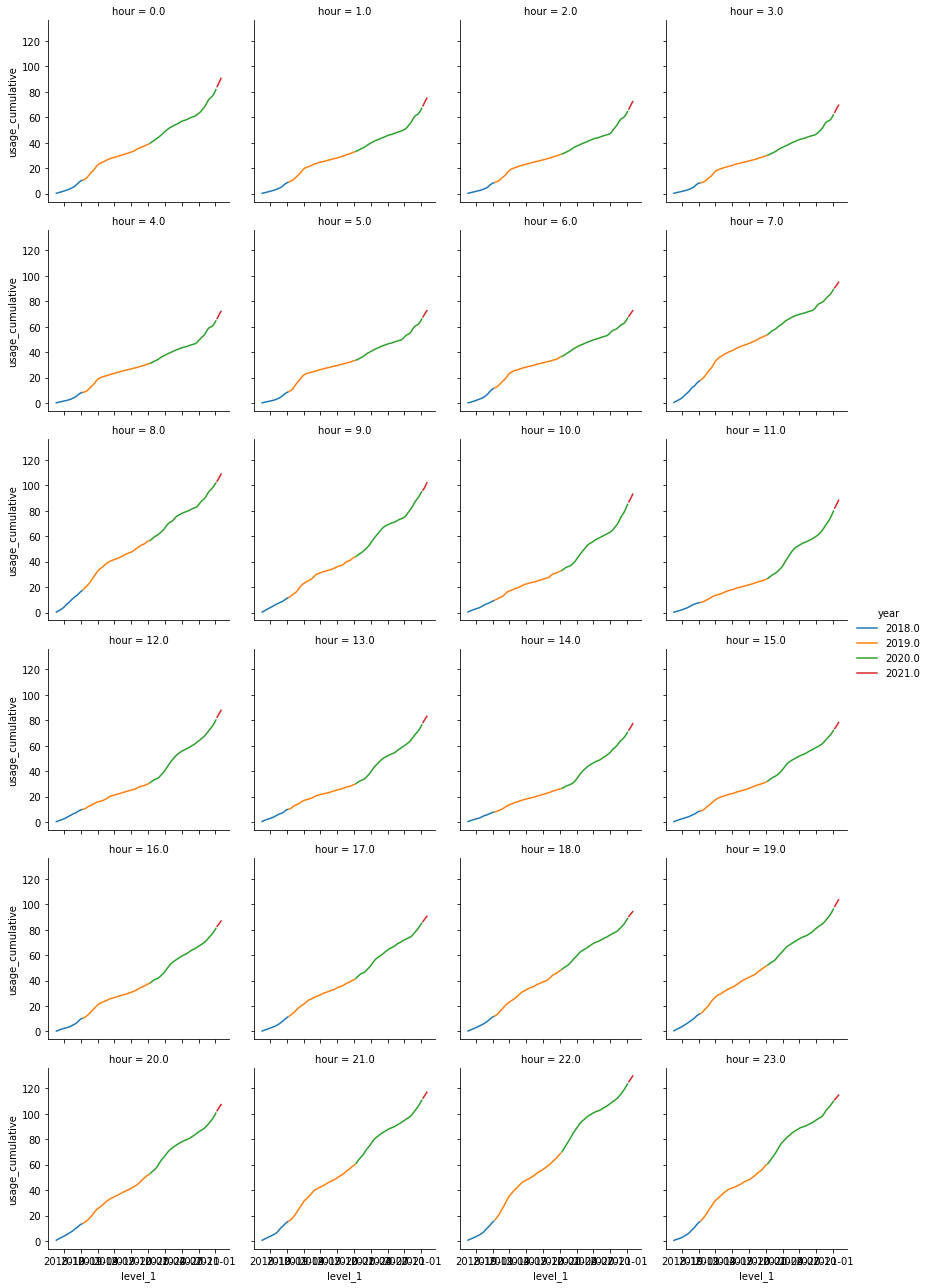

In [120]:
g = sns.FacetGrid(df_hourly_yoy.reset_index(), hue='year', col="hour", col_wrap=4)
g.map(sns.lineplot, "level_1", "usage_cumulative").add_legend()

In [131]:
df_hourly_yoy.reset_index()

,hour,level_1,month,week_of_year,year,usage_kwh_rolling,last_year,yoy_delta,delta_yoy_cumulative,usage_cumulative,usage_weekly_pct_change,usage_monthly_pct_change,usage_yearly_pct_change
0,0.0,2018-08-05,8.0,31.0,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,2018-08-12,8.0,32.0,2018.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2018-08-19,8.0,33.0,2018.0,0.293333,NaN,NaN,NaN,0.293333,NaN,NaN,NaN
3,0.0,2018-08-26,8.0,34.0,2018.0,0.310000,NaN,NaN,NaN,0.603333,0.056818,NaN,NaN
4,0.0,2018-09-02,8.0,35.0,2018.0,0.283333,NaN,NaN,NaN,0.886667,-0.086022,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3139,23.0,2021-01-03,1.0,53.0,2020.0,1.416667,0.913333,0.503333,5.586667,109.833333,0.029056,0.291793,0.551095
3140,23.0,2021-01-10,1.0,1.0,2021.0,1.266667,0.776667,0.490000,6.076667,111.100000,-0.105882,0.098266,0.630901
3141,23.0,2021-01-17,1.0,2.0,2021.0,1.163333,1.246667,-0.083333,5.993333,112.263333,-0.081579,-0.105128,-0.066845
3142,23.0,2021-01-24,1.0,3.0,2021.0,1.126667,1.373333,-0.246667,5.746667,113.390000,-0.031519,-0.181598,-0.179612


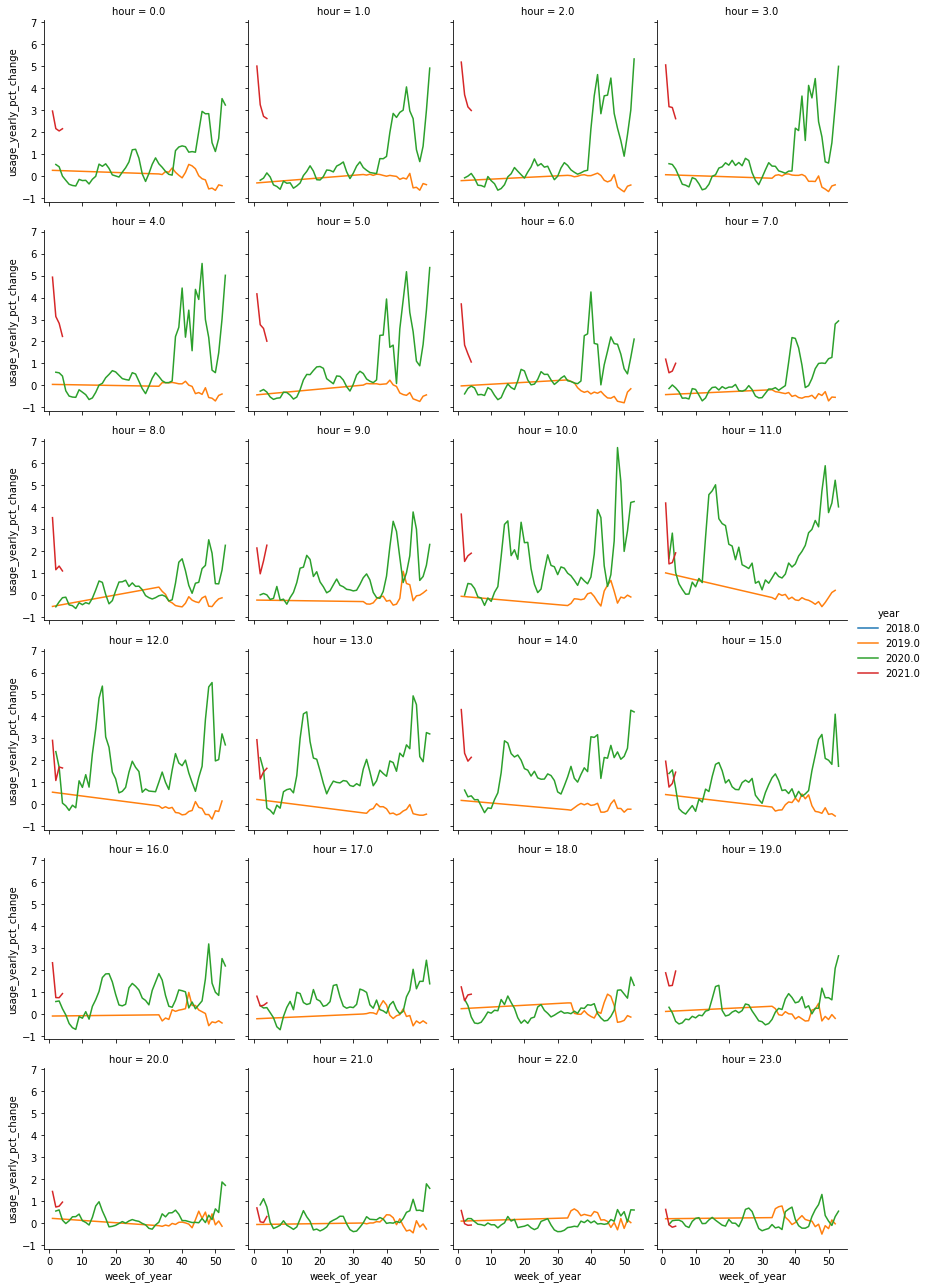

In [133]:
g = sns.FacetGrid(
    df_hourly_yoy.reset_index(),
    hue='year', col="hour", col_wrap=4)
g.map(sns.lineplot, "week_of_year", "usage_yearly_pct_change").add_legend()

In [24]:
def plot_yoy_usage_change(hour):
    df_hourly = df[df.hour == hour].resample('M').sum()
    df_hourly['usage_kwh_previous_year'] = df_hourly.usage_kwh.shift(12)
    df_hourly['usage_kwh_yoy'] = df_hourly.usage_kwh - df_hourly.usage_kwh_previous_year
    df_hourly['date'] = df_hourly.index.date
    palette = sns.color_palette('icefire_r', n_colors=len(df_hourly))
    rank = df_hourly.usage_kwh_yoy.argsort().argsort()
    plot_ = sns.barplot(data=df_hourly, palette=np.array(palette[::-1])[rank], x='date', y='usage_kwh_yoy')
    plot_.set_title(f'Monthly Energy Usage YoY change for {hour}:00')
    for ind, label in enumerate(plot_.get_xticklabels()):
        if ind % 3 == 0:  # every 3rd label is kept
            label.set_visible(True)
        else:
            label.set_visible(False)

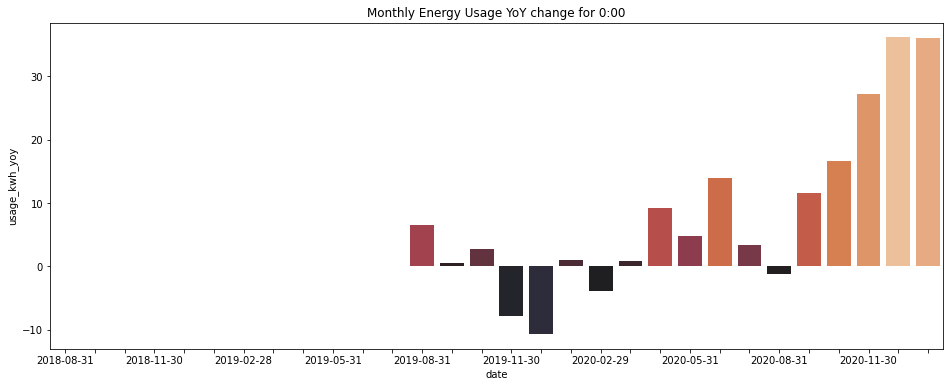

In [25]:
plot_yoy_usage_change(0)

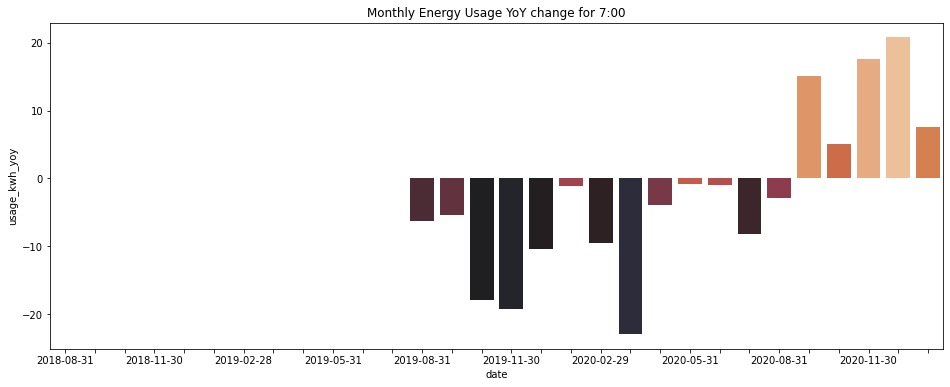

In [26]:
plot_yoy_usage_change(7)

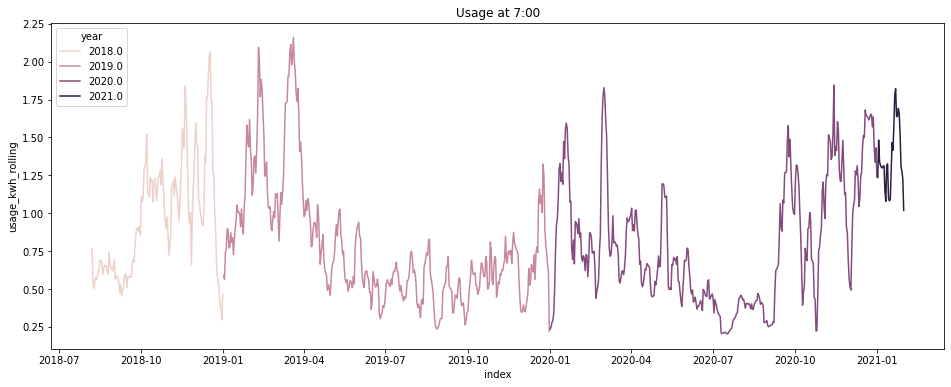

In [690]:
plot_hour(7)

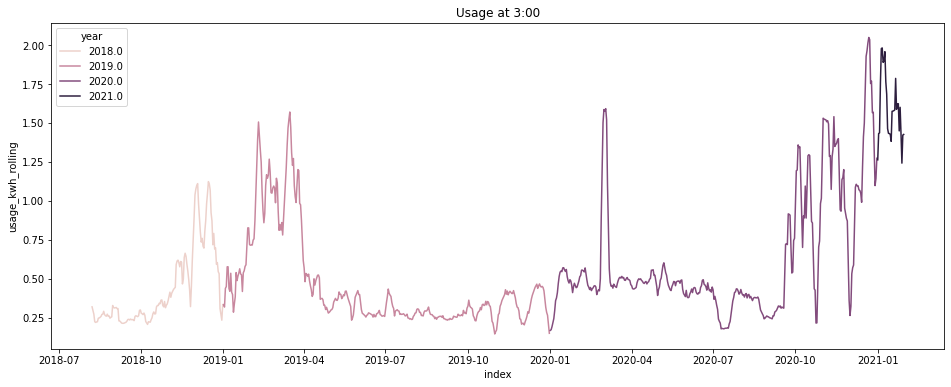

In [691]:
plot_hour(3)

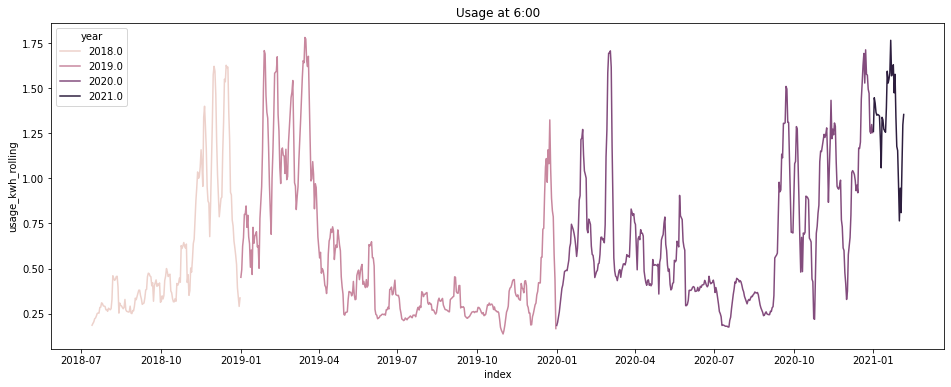

In [350]:
plot_hour(6)

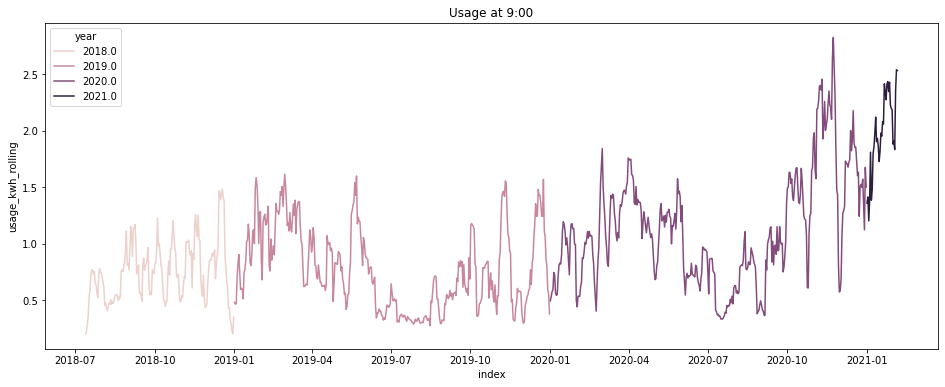

In [351]:
plot_hour(9)

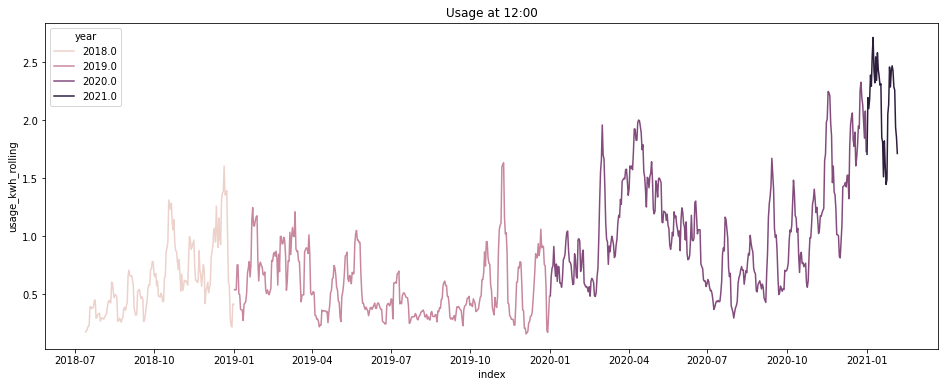

In [352]:
plot_hour(12)

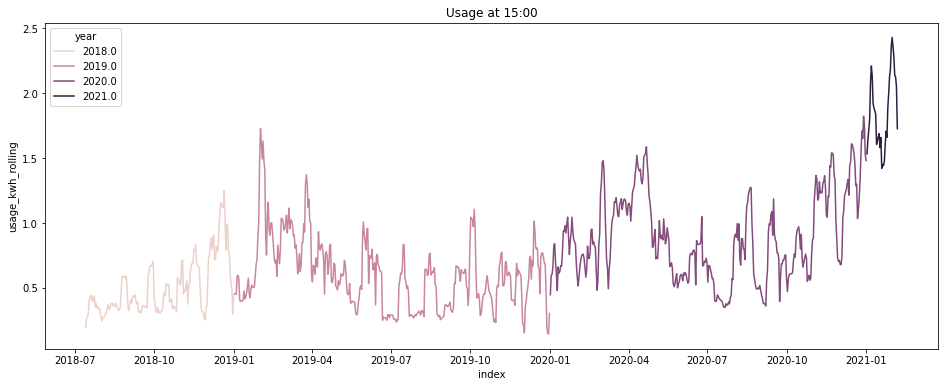

In [353]:
plot_hour(15)

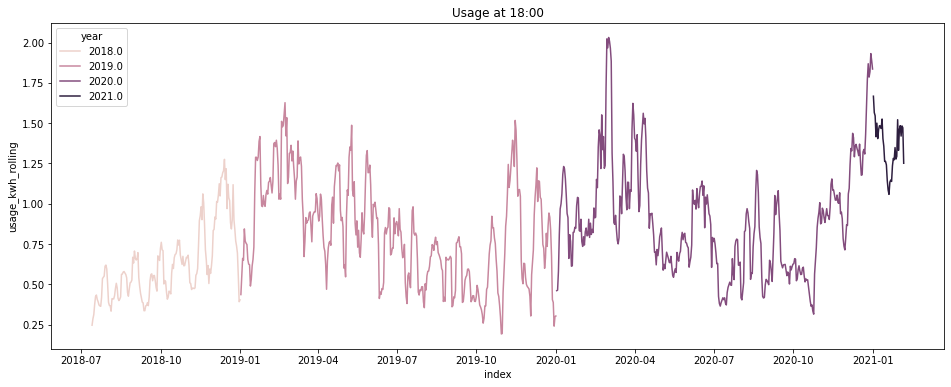

In [354]:
plot_hour(18)

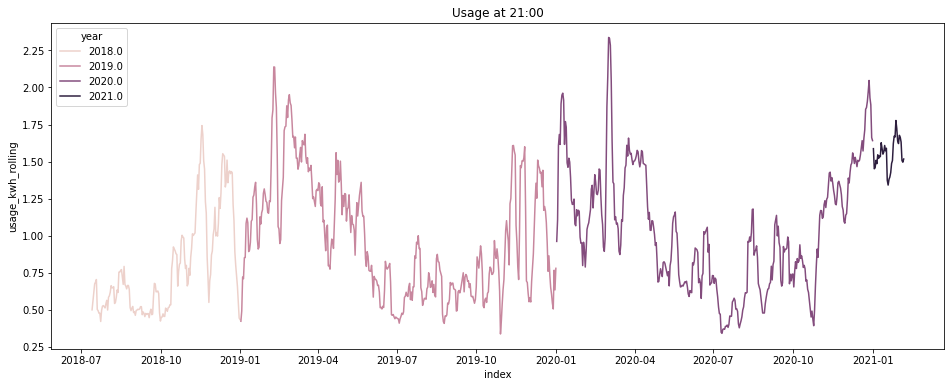

In [355]:
plot_hour(21)

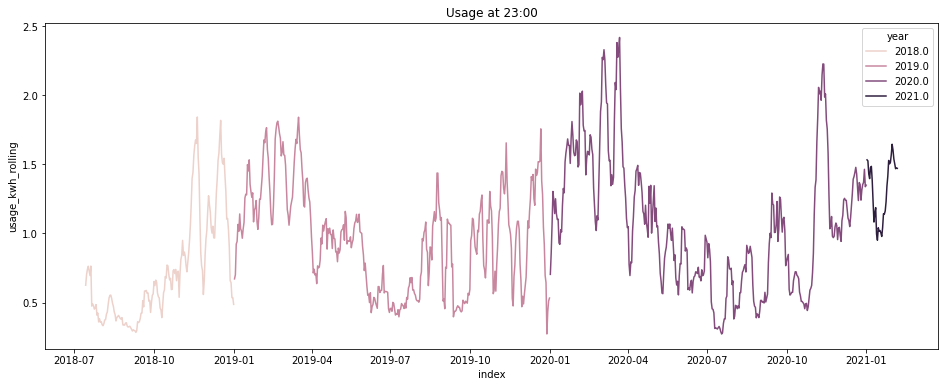

In [356]:
plot_hour(23)

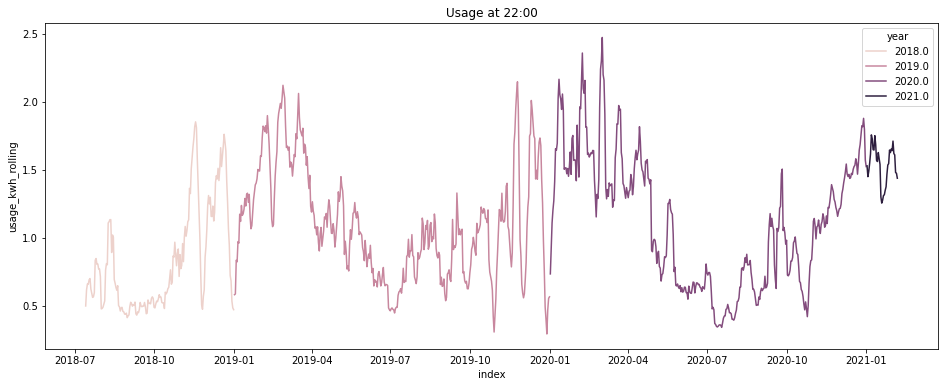

In [357]:
plot_hour(22)

In [728]:
df_monthly_by_hour = df.groupby(by='hour').apply(lambda g: g.groupby('month').usage_kwh.mean())
df_monthly_by_hour

month,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
hour,,,,,,,,,,,,
0.0,1.197097,1.148596,1.158387,0.685167,0.695000,0.571500,0.450323,0.457419,0.506889,0.723333,0.962333,1.076022
1.0,0.961304,0.946667,0.946290,0.471167,0.480161,0.391833,0.321613,0.307634,0.392222,0.563656,0.754409,0.887419
2.0,0.901413,0.917193,0.795500,0.445167,0.417258,0.353500,0.279355,0.292903,0.359333,0.553871,0.704778,0.869570
3.0,0.864891,0.901053,0.769677,0.440000,0.421613,0.352333,0.291935,0.298065,0.352556,0.508710,0.692889,0.796774
4.0,0.875543,0.959649,0.816613,0.465833,0.418871,0.345833,0.286774,0.293118,0.441000,0.497957,0.676222,0.785806
5.0,0.900978,1.110702,0.824032,0.430333,0.393387,0.348000,0.281129,0.273226,0.457778,0.474301,0.692778,0.798065
6.0,0.973696,1.036316,0.872903,0.534167,0.495806,0.355833,0.282097,0.310215,0.514000,0.490538,0.790222,0.901828
7.0,1.140978,1.121053,1.152903,0.722833,0.745484,0.458500,0.443226,0.493548,0.691222,0.859677,1.021889,1.041935
8.0,1.295217,1.224035,1.281774,0.954500,0.949194,0.615333,0.524194,0.670000,0.867000,0.940645,1.129333,1.052151


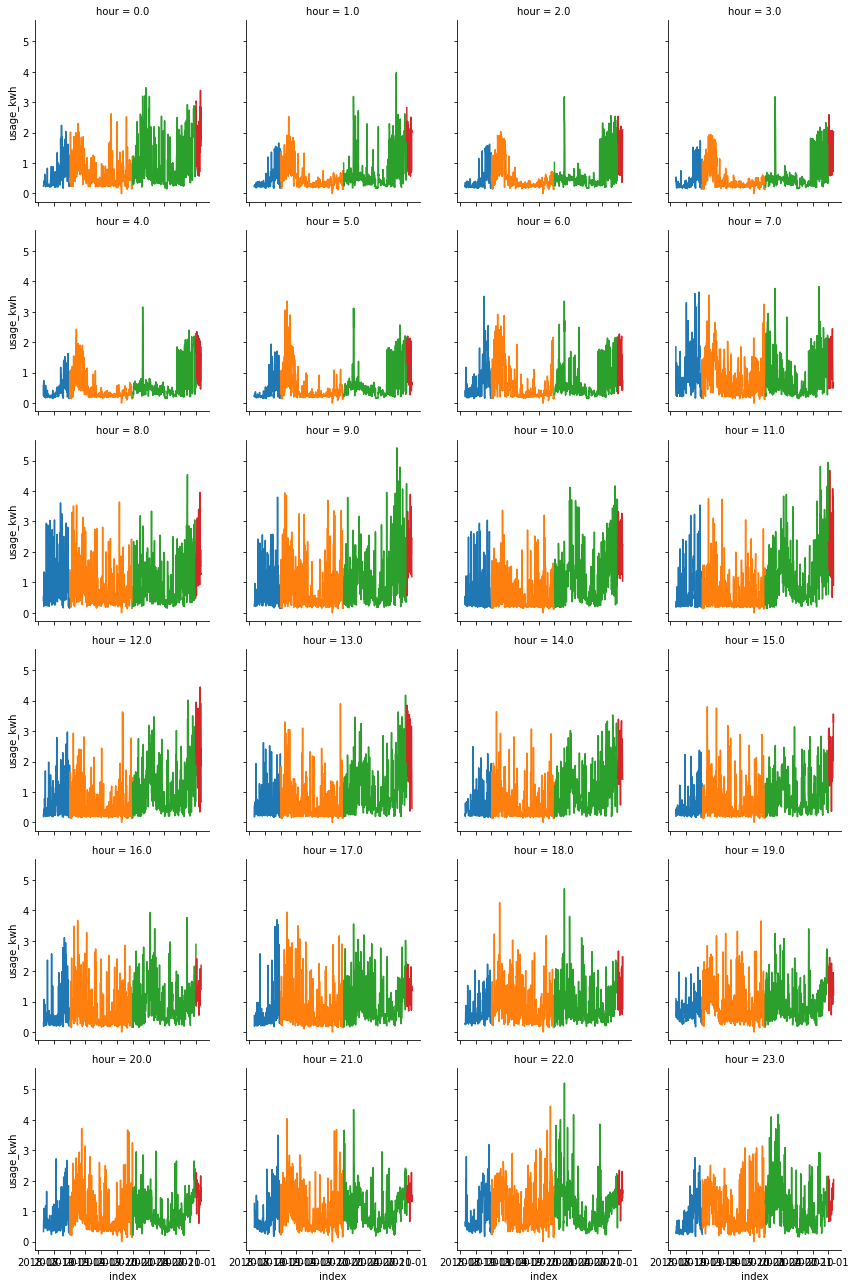

In [715]:
g = sns.FacetGrid(df.reset_index(), hue='year', col="hour", col_wrap=4)
g.map(sns.lineplot, "index", "usage_kwh", estimator=np.sum)

## Nest data analysis

Let's now turn to look at how our Nest thermostat performed

### Data ingestion

In [732]:
df_thermostat = pd.read_csv(filepath_or_buffer=f"{os.getenv('PATH_TO_NEST_THERMOSTAT_CSV_ROOT_FOLDER')}/2020/01/2020-01-sensors.csv")

In [765]:
from glob import glob
all_files = glob(os.path.expanduser(os.path.join(os.getenv('PATH_TO_NEST_THERMOSTAT_CSV_ROOT_FOLDER'), "**", "*-sensors.csv")), recursive=True)

In [898]:
df_from_each_file = []
for f in all_files:
    try:
        df_from_each_file.append(pd.read_csv(f))
    except:
        # Do nothing if it borks
        None

df_nest_thermostat = pd.concat(df_from_each_file, ignore_index=True)

In [899]:
thermostat_features = {
    'dt': lambda df: df.apply(lambda r: datetime.strptime(f'{r.Date}T{r.Time}', '%Y-%m-%dT%H:%M'), axis=1),
    'year': lambda df: df.dt.apply(lambda dt: dt.year),
    'month': lambda df: df.dt.apply(lambda dt: dt.month),
    'day_of_year': lambda df: df.dt.apply(lambda dt: dt.dayofyear)
}
for attr, transform in thermostat_features.items():
    df_nest_thermostat[attr] = transform(df_nest_thermostat)

In [900]:
df_nest_thermostat.set_index('dt', inplace=True)

In [901]:
df_nest_thermostat.sort_values(by='dt', inplace=True)

### Analysis

We first turn to look at the general indoor temperature over the past years of Nest ownership.

We can see that in 2020, the home was warmer on average

<AxesSubplot:xlabel='day_of_year', ylabel='avg(temp)'>

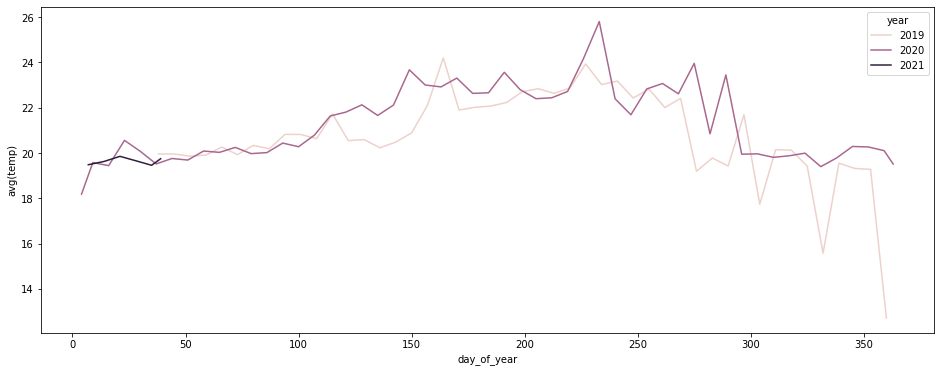

In [902]:
sns.lineplot(data=df_nest_thermostat.resample('W').median(), x='day_of_year', y='avg(temp)', hue='year')

In [924]:
df_nest_thermostat['temp_1_year_ago'] = df_nest_thermostat['avg(temp)'].shift(4 * 24 * 365)
df_nest_thermostat['temp_diff_yoy'] = df_nest_thermostat['avg(temp)'] - df_nest_thermostat['temp_1_year_ago']

Text(0.5, 1.0, 'Median monthly temperature change YoY')

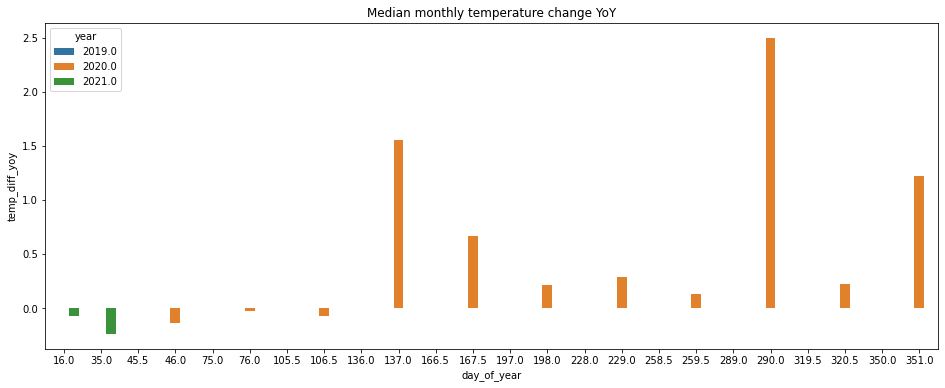

In [929]:
sns.barplot(data=df_nest_thermostat.resample('M').median(), x='day_of_year', y='temp_diff_yoy', hue='year').set_title('Median monthly temperature change YoY')

...and less humid

<AxesSubplot:xlabel='day_of_year', ylabel='avg(humidity)'>

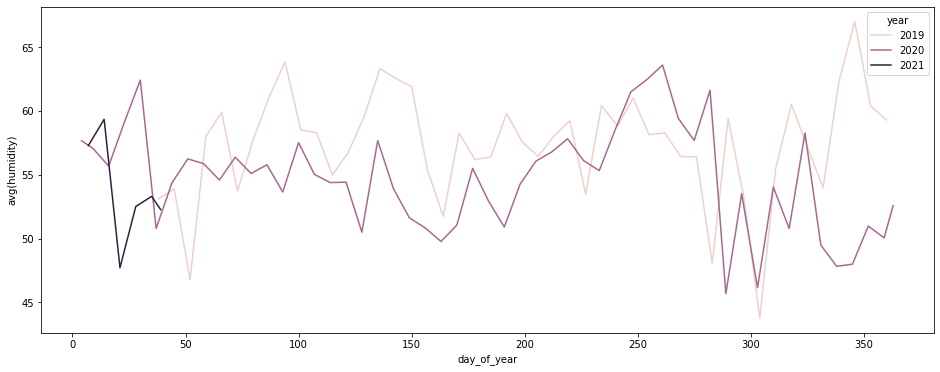

In [930]:
sns.lineplot(data=df_nest_thermostat.resample('W').median(), x='day_of_year', y='avg(humidity)', hue='year')